### 교차검증
- k-fold cross validation
- stratified k-fold cross validation

교차 검증 구현하기

In [1]:
import numpy as np
from sklearn.model_selection import KFold

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])

# KFold 객체 생성
kf = KFold(n_splits=2)

print(kf.get_n_splits(X))
print(kf)

for train_idx, test_idx in kf.split(X):
    print('--- idx')
    print(train_idx, test_idx)
    print('--- train data')
    print(X[train_idx])
    print('--- test data')
    print(X[test_idx])
        

2
KFold(n_splits=2, random_state=None, shuffle=False)
--- idx
[2 3] [0 1]
--- train data
[[1 2]
 [3 4]]
--- test data
[[1 2]
 [3 4]]
--- idx
[0 1] [2 3]
--- train data
[[1 2]
 [3 4]]
--- test data
[[1 2]
 [3 4]]


#### 와인 데이터로 다시 실습해보기

In [18]:
import pandas as pd

red_wine = pd.read_csv('./data/winequality-red.csv', sep=';')
white_wine = pd.read_csv('./data/winequality-white.csv', sep=';')

red_wine['color'] = 1.
white_wine['color'] = 0.

wine = pd.concat([red_wine, white_wine])

# 맛 등급에 따른 분류 컬럼 생성
wine['taste'] = [1. if grade >= 5 else 0. for grade in wine['quality']]

X = wine.drop(['taste', 'quality'], axis=1)
y = wine['taste']

In [4]:
# 지난번에 했던 의사결정 나무 모델
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

wine_tree = DecisionTreeClassifier(max_depth=2, random_state=13)
wine_tree.fit(X_train, y_train)

y_pred_tr = wine_tree.predict(X_train)
y_pred_test = wine_tree.predict(X_test)

print('Train acc : ', accuracy_score(y_train, y_pred_tr))
print('Test acc : ', accuracy_score(y_test, y_pred_test))

Train acc :  0.9619010967866076
Test acc :  0.9684615384615385


In [5]:
# 데이터를 위와 같이 분리하는 것이 최선인가?
# KFold로 한번 살펴보자

In [6]:
# KFold 살펴보기
kfold = KFold(n_splits=5)
wine_tree_cv = DecisionTreeClassifier(max_depth=2, random_state=13)

for train_idx, test_idx in kfold.split(X):
    print(len(train_idx), len(test_idx))

5197 1300
5197 1300
5198 1299
5198 1299
5198 1299


In [9]:
# 각각의 fold에 대한 학습 수 accuracy 측정
cv_accuracy = []

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    wine_tree_cv.fit(X_train, y_train)
    pred = wine_tree_cv.predict(X_test)
    cv_accuracy.append(accuracy_score(y_test, pred))

cv_accuracy

[0.9623076923076923,
 0.9553846153846154,
 0.9545804464973057,
 0.9645881447267128,
 0.9738260200153964]

In [10]:
# acc간 분산이 크지 않다면 평균을 대표값으로 한다
np.mean(cv_accuracy)

0.9621373837863446

### Stratified K-fold

In [11]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5)
wine_tree_cv = DecisionTreeClassifier(max_depth=5, random_state=13)

cv_accuracy = []

for train_idx, test_idx in skfold.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    wine_tree_cv.fit(X_train, y_train)
    pred = wine_tree_cv.predict(X_test)
    cv_accuracy.append(accuracy_score(y_test, pred))

cv_accuracy

[0.9361538461538461,
 0.9607692307692308,
 0.9630484988452656,
 0.962278675904542,
 0.9599692070823711]

In [12]:
# ac의 평균이 더 나쁘다
np.mean(cv_accuracy)

0.9564438917510512

### 위 과정을 보다 간편히 -> cross_val_score()

In [13]:
from sklearn.model_selection import cross_val_score

skfold = StratifiedKFold(n_splits=5)
wine_tree_cv = DecisionTreeClassifier(max_depth=2, random_state=13)

cross_val_score(wine_tree_cv, X, y, scoring=None, cv=skfold)
# (estimator, X, y, scoring, CV방법)

array([0.96230769, 0.96076923, 0.9630485 , 0.9630485 , 0.96227868])

In [15]:
# depth가 높다고 항상 acc가 좋아지는 것도 아니다
wine_tree_cv = DecisionTreeClassifier(max_depth=5, random_state=13)
cross_val_score(wine_tree_cv, X, y, scoring=None, cv=skfold)

array([0.93615385, 0.96076923, 0.9630485 , 0.96227868, 0.95996921])

In [16]:
# train score와 함께 보고싶다면
from sklearn.model_selection import cross_validate
cross_validate(wine_tree_cv, X, y, scoring=None, cv=skfold, return_train_score=True)

{'fit_time': array([0.01988816, 0.01475191, 0.0154779 , 0.01317692, 0.01306581]),
 'score_time': array([0.00244594, 0.0018158 , 0.00190902, 0.00221705, 0.00202012]),
 'test_score': array([0.93615385, 0.96076923, 0.9630485 , 0.96227868, 0.95996921]),
 'train_score': array([0.9680585 , 0.96594189, 0.9653713 , 0.96691035, 0.96691035])}

### 하이퍼파라미터 튜닝

In [20]:
# 새로 로드
import pandas as pd

red_wine = pd.read_csv('./data/winequality-red.csv', sep=';')
white_wine = pd.read_csv('./data/winequality-white.csv', sep=';')

red_wine['color'] = 1.
white_wine['color'] = 0.

wine = pd.concat([red_wine, white_wine])

# 맛 등급에 따른 분류 컬럼 생성
wine['taste'] = [1. if grade >= 5 else 0. for grade in wine['quality']]

X = wine.drop(['taste', 'quality'], axis=1)
y = wine['taste']

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

params = {'max_depth' : [2,4,7,10]}
# dictionary 형
wine_tree = DecisionTreeClassifier(max_depth=2, random_state=13)

gridsearch = GridSearchCV(estimator=wine_tree, param_grid=params, cv=5)
gridsearch.fit(X, y)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=2, random_state=13),
             param_grid={'max_depth': [2, 4, 7, 10]})

In [24]:
# GridSearchCV 결과 확인
import pprint

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(gridsearch.cv_results_)

{   'mean_fit_time': array([0.00878825, 0.01163521, 0.01766672, 0.0237936 ]),
    'mean_score_time': array([0.00234833, 0.0018702 , 0.00179281, 0.00205965]),
    'mean_test_score': array([0.96229052, 0.95936768, 0.95505762, 0.94182341]),
    'param_max_depth': masked_array(data=[2, 4, 7, 10],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object),
    'params': [   {'max_depth': 2},
                  {'max_depth': 4},
                  {'max_depth': 7},
                  {'max_depth': 10}],
    'rank_test_score': array([1, 2, 3, 4], dtype=int32),
    'split0_test_score': array([0.96230769, 0.94615385, 0.94153846, 0.90538462]),
    'split1_test_score': array([0.96076923, 0.96076923, 0.95923077, 0.95153846]),
    'split2_test_score': array([0.9630485 , 0.9630485 , 0.96073903, 0.95458045]),
    'split3_test_score': array([0.9630485 , 0.96381832, 0.95612009, 0.94611239]),
    'split4_test_score': array([0.96227868, 0.9630485 , 0.95765974, 0.9515011

In [25]:
gridsearch.best_estimator_

DecisionTreeClassifier(max_depth=2, random_state=13)

In [26]:
gridsearch.best_score_

0.9622905193343992

In [27]:
gridsearch.best_params_

{'max_depth': 2}

#### pipeline에 GridSearch 적용하기

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

estimators = [('scaler', StandardScaler()),
             ('clf', DecisionTreeClassifier(random_state=13))]

pipe = Pipeline(estimators)

param_grid = [ {'clf__max_depth' : [2, 4, 7, 10]} ]

Gridsearch = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, verbose=1)
Gridsearch.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.4s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=13))]),
             param_grid=[{'clf__max_depth': [2, 4, 7, 10]}], verbose=1)

In [37]:
Gridsearch.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', DecisionTreeClassifier(max_depth=2, random_state=13))])

In [38]:
Gridsearch.best_score_

0.9622905193343992

In [39]:
Gridsearch.cv_results_

{'mean_fit_time': array([0.01182132, 0.01315651, 0.01983809, 0.02460098]),
 'std_fit_time': array([0.00208845, 0.00015779, 0.00087918, 0.00096744]),
 'mean_score_time': array([0.00227394, 0.00174308, 0.00215631, 0.00174499]),
 'std_score_time': array([4.63487327e-04, 6.09178832e-05, 4.29177480e-04, 7.82467838e-05]),
 'param_clf__max_depth': masked_array(data=[2, 4, 7, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__max_depth': 2},
  {'clf__max_depth': 4},
  {'clf__max_depth': 7},
  {'clf__max_depth': 10}],
 'split0_test_score': array([0.96230769, 0.94615385, 0.94153846, 0.90615385]),
 'split1_test_score': array([0.96076923, 0.96076923, 0.95923077, 0.95153846]),
 'split2_test_score': array([0.9630485 , 0.9630485 , 0.96073903, 0.95535027]),
 'split3_test_score': array([0.9630485 , 0.96381832, 0.95612009, 0.94688222]),
 'split4_test_score': array([0.96227868, 0.9630485 , 0.95765974, 0.95150115]),
 'mean_test_scor

#### Tree로 확인해보기

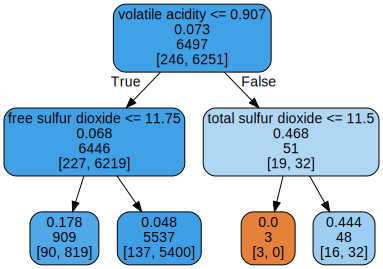

In [30]:
from graphviz import Source
from sklearn.tree import export_graphviz

Source(export_graphviz(gridsearch.best_estimator_, feature_names=X.columns, label=['W', 'R'],
                      rounded=True, filled=True))

In [40]:
# 표로 정리해보기
import pandas as pd

score_df = pd.DataFrame(Gridsearch.cv_results_)
score_df[['params', 'rank_test_score', 'mean_test_score', 'std_test_score']]
## accuracy들의 평균과 표준편차를 보자

,params,rank_test_score,mean_test_score,std_test_score
0,{'clf__max_depth': 2},1,0.962291,0.000832
1,{'clf__max_depth': 4},2,0.959368,0.006685
2,{'clf__max_depth': 7},3,0.955058,0.006933
3,{'clf__max_depth': 10},4,0.942285,0.018264
